In [1]:
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
from jaxutils import Dataset

import tqdm
import matplotlib.pyplot as plt
import ternary
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Imports from our code base
from elliptical_slice_sampler_jax import elliptical_slice_jax
from active_search import get_next_y, get_next_candidate_baseline
from plotting import plot_candidate, plot_std
from gp_model import update_model, make_preds
from search_no_gpjax import generate_true_function, sample_from_posterior

# Generate data

In [3]:
n_grid = 10

nx, ny = (n_grid, n_grid)
x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)
xv, yv = jnp.meshgrid(x, y)
train_x = jnp.array([xv.flatten(),yv.flatten()]).T
# filter out points that are greater than 1
design_space = train_x[train_x.sum(1) <= 1]
pts = []
for x in design_space:
    pts.append(jnp.array([x[0], x[1], 1-x.sum()]))
    
knot_N = len(design_space)

#set seed
npr.seed(10); rng_key = jrnd.PRNGKey(1)

# generate energies
true_y, true_envelope = generate_true_function(design_space, knot_N)

# compute tight points w.r.t. generated data
tights = (true_y - true_envelope) <= 1e-3
tight_designs = design_space[tights.ravel(),:]
tight_pts = []
for x in tight_designs:
    tight_pts.append(jnp.array([x[0], x[1], 1-x.sum()]))

# observations
train_x = jnp.array([design_space[0], design_space[-1]])
train_y = jnp.array([true_y[0], true_y[-1]])
data = (train_x, train_y)

# Baseline: no convex hull information

Iteration:  0
CPU times: user 2.66 s, sys: 32 ms, total: 2.69 s
Wall time: 2.71 s


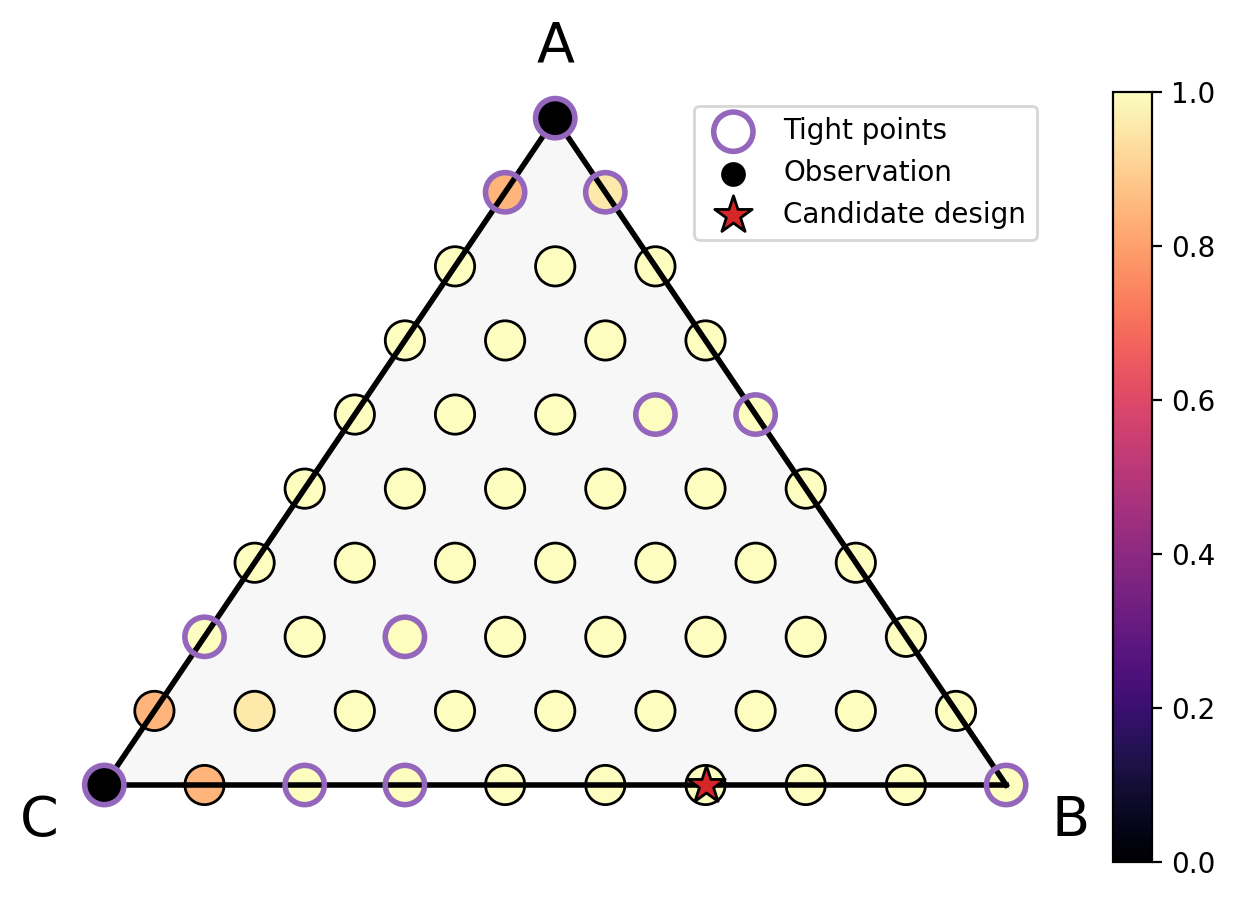

Iteration:  1
CPU times: user 2.28 s, sys: 19.1 ms, total: 2.3 s
Wall time: 2.34 s


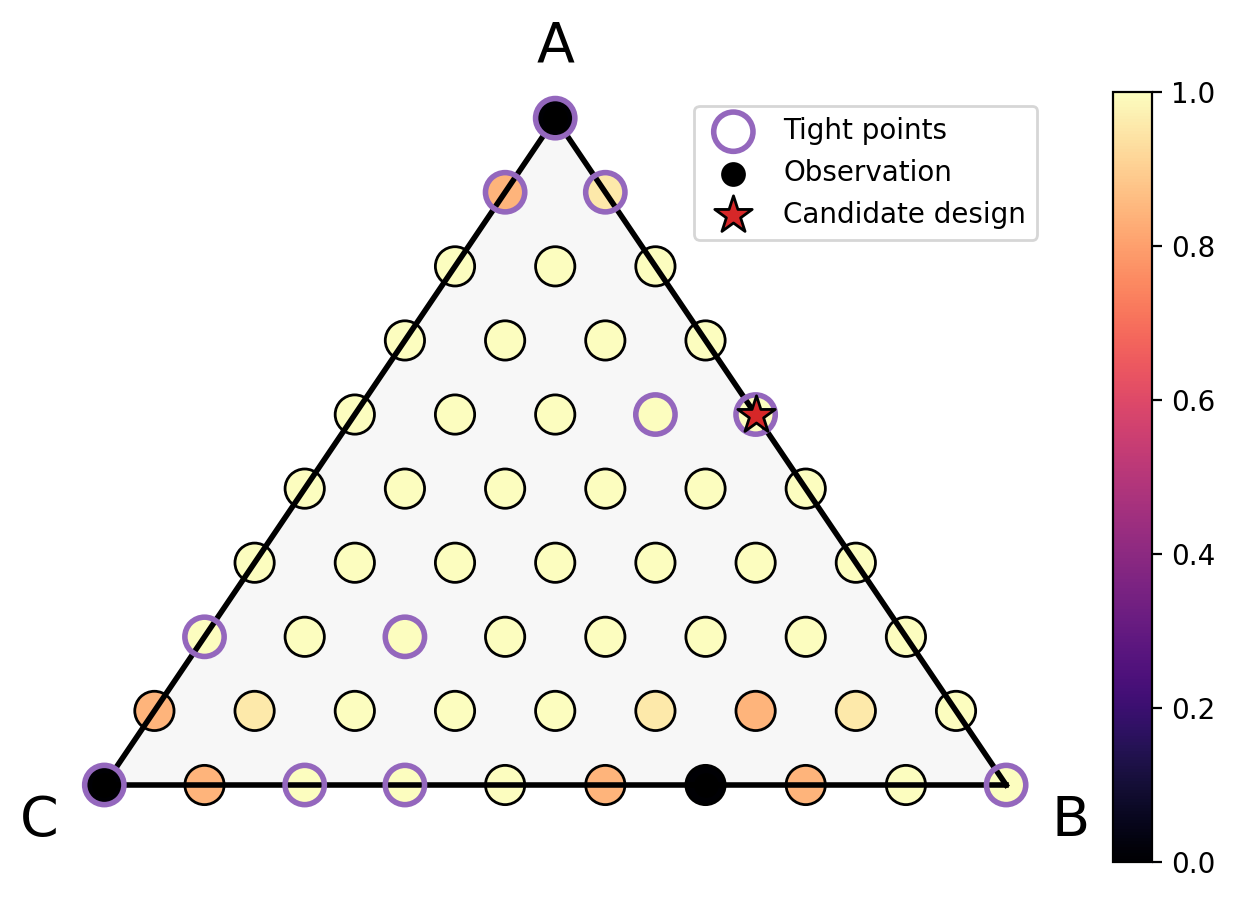

Iteration:  2
CPU times: user 2.13 s, sys: 16.3 ms, total: 2.14 s
Wall time: 2.16 s


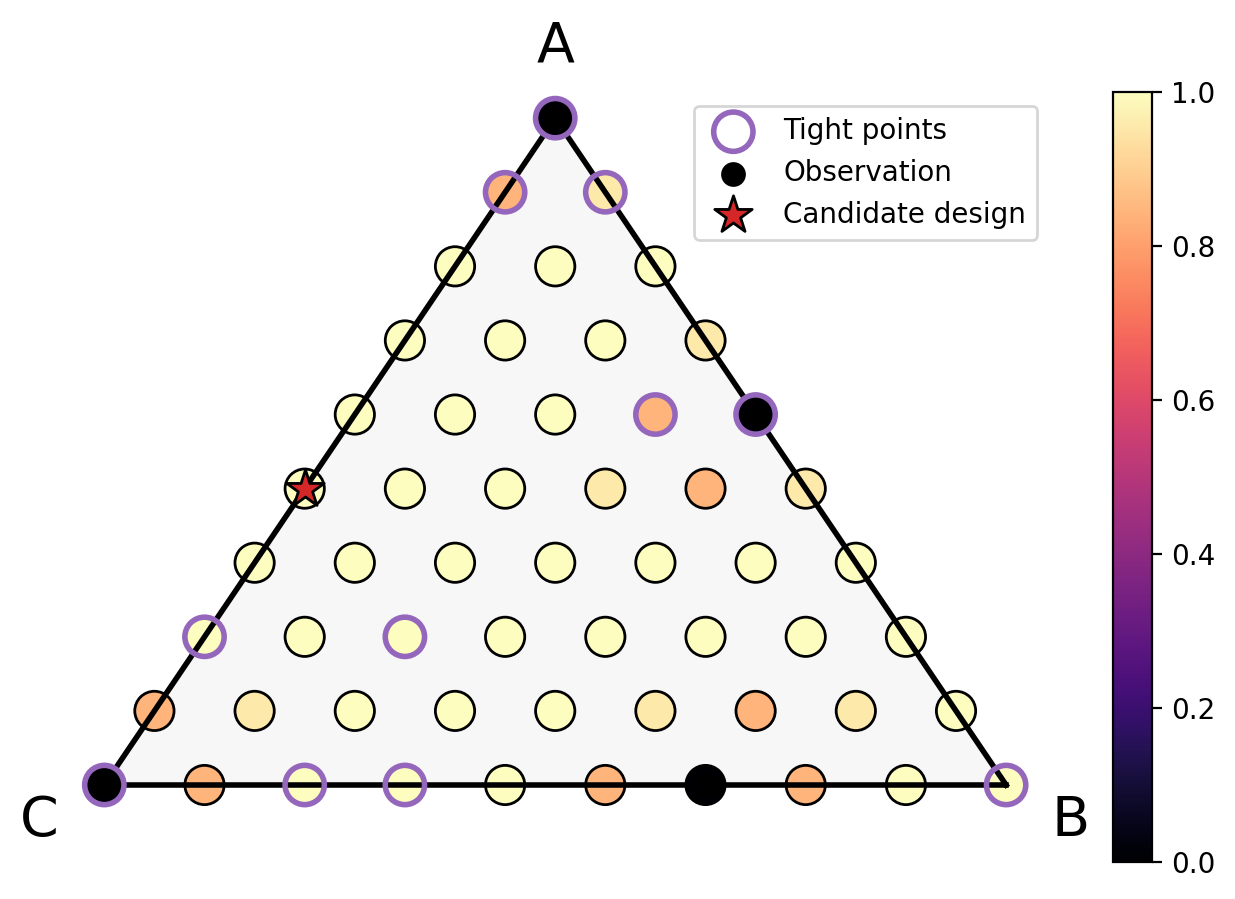

Iteration:  3
CPU times: user 2.09 s, sys: 15.2 ms, total: 2.1 s
Wall time: 2.1 s


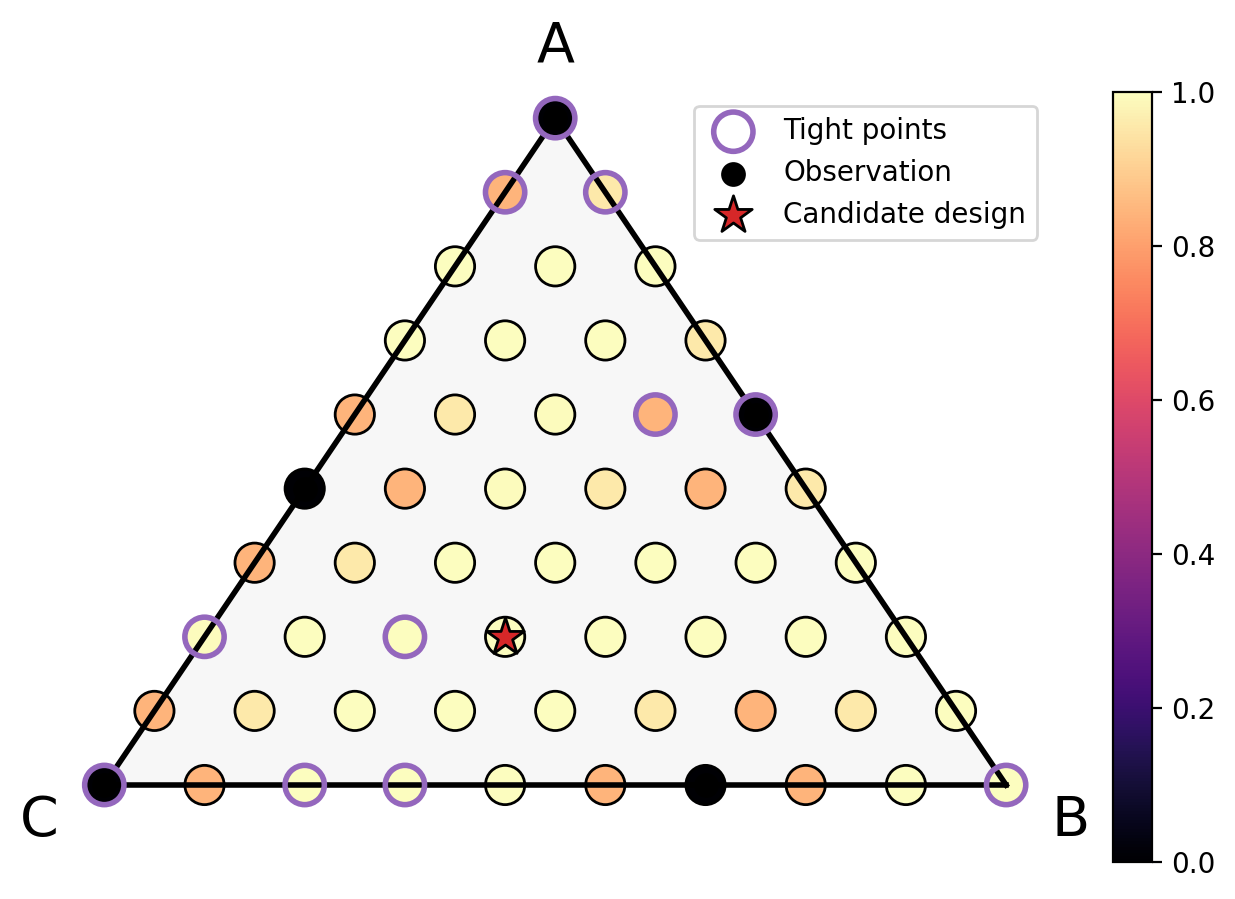

Iteration:  4
CPU times: user 2.06 s, sys: 14.9 ms, total: 2.07 s
Wall time: 2.07 s


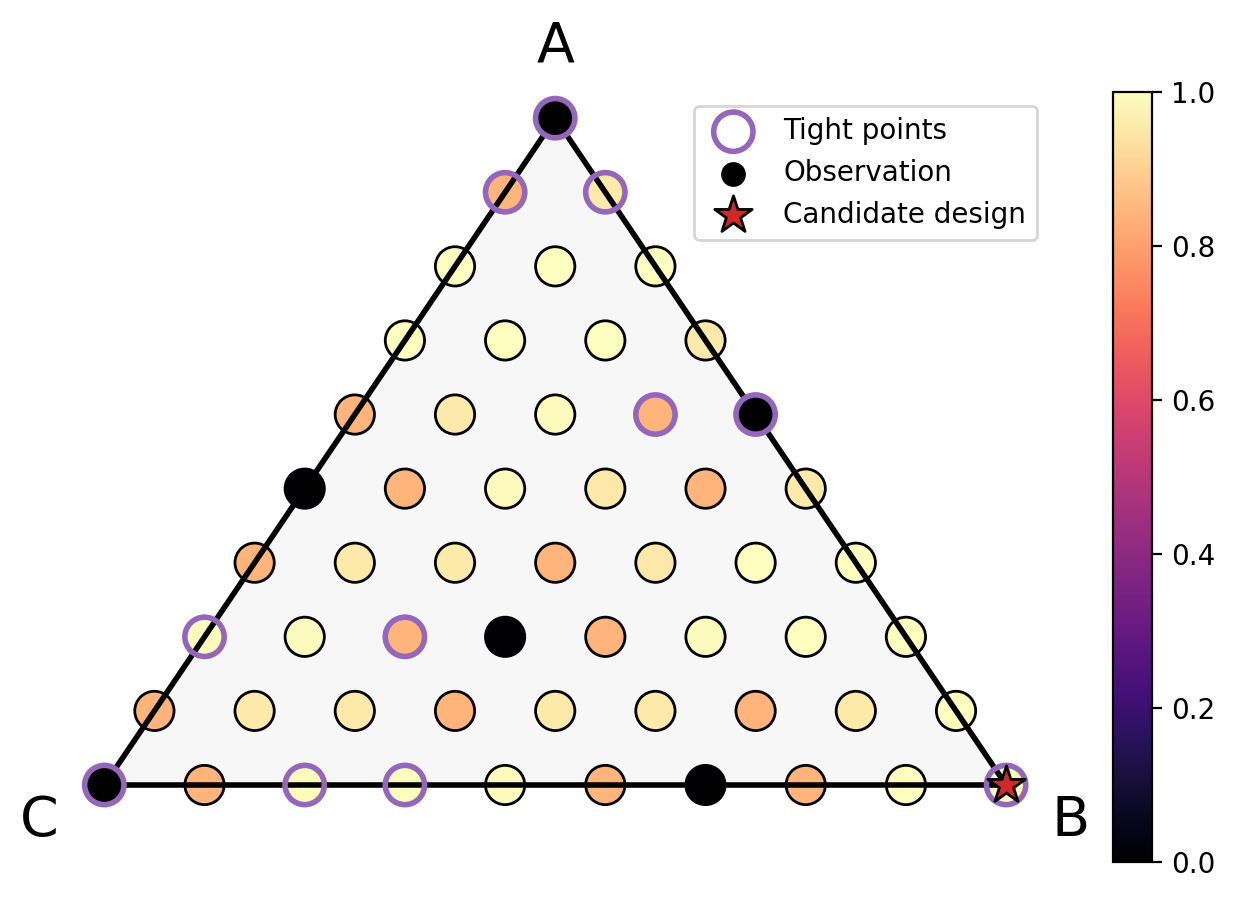

Iteration:  5
CPU times: user 2.08 s, sys: 17.8 ms, total: 2.1 s
Wall time: 2.11 s


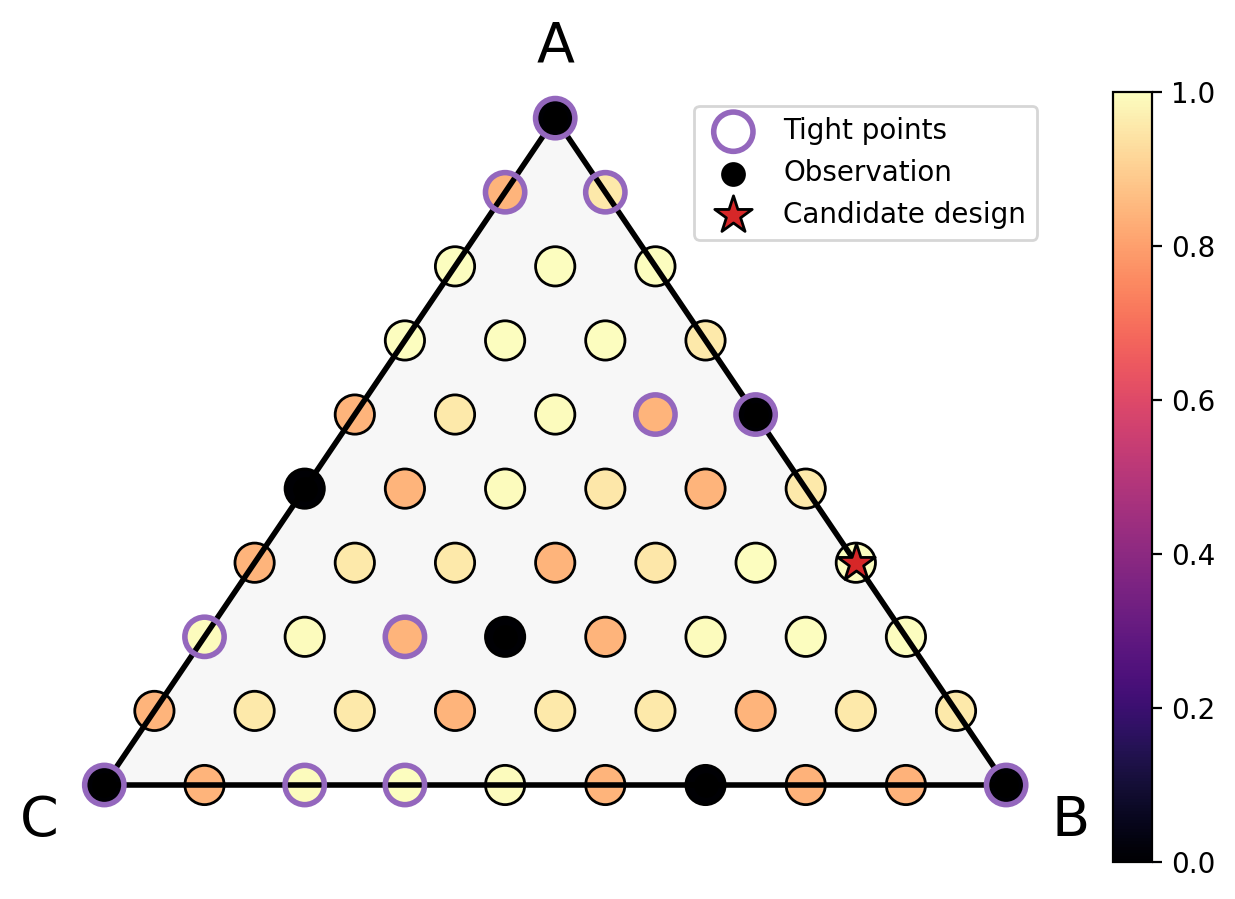

In [4]:
## baseline

num_iters = 6

dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])
designs = design_space[1:-1]

# Update the model given the data above
pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

for i in range(num_iters):
    
    print("Iteration: ", i)    
    # get candidate design
    %time next_x, entropy_change = get_next_candidate_baseline(posterior, params, dataset, designs, design_space)
    # get the index of candidate w.r.t. full design space
    next_x_ind = (design_space == next_x).sum(1).argmax()

    # plot posterior std
    plot_std(posterior, dataset, params, pts, next_x=next_x_ind, tight_pts=tight_pts, scale=n_grid*10, plot_design=False)
    
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(true_y[next_x_ind]))
    designs = jnp.delete(designs, (designs == next_x).sum(1).argmax(), axis=0)
    
    pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

# Convex-hull-aware active search